In [146]:
import glob

import numpy as np
import pandas as pd

import os
import math
import random

import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline
K.set_image_data_format('channels_last')

In [147]:
DATA_FOLDER = 'data'
sample_models = ['00087a6bd4dc', '169f5f6d8c9d', 'f7ad86e13ed7']
sample_number = [3, 6, 9]

In [148]:
from textwrap import wrap

def display(images, cols=None, maxcols=10, width=16, titles=None):
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    plt.rc('axes', grid=False)
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(
                fig1,
                111,
                nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                axes_pad=(0.1, 0.6)
            )

    for index, img in enumerate(images):
        grid1[index].grid = False
        if titles is not None:
            grid1[index].set_title('\n'.join(wrap(titles[index], width=25)))
        if len(img.shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)

In [149]:
def combine_images(dataset, fmt):
    return [os.path.join(DATA_FOLDER, dataset, '{}_{:02d}.{}'.format(model, num, fmt)) for model in sample_models for num in sample_number]
image_names = combine_images('train', 'jpg')
mask_names = combine_images('test', 'gif')

In [150]:
images = [mpimg.imread(fname) for fname in image_names]
#masks = [mpimg.imread(fname) for fname in mask_names]

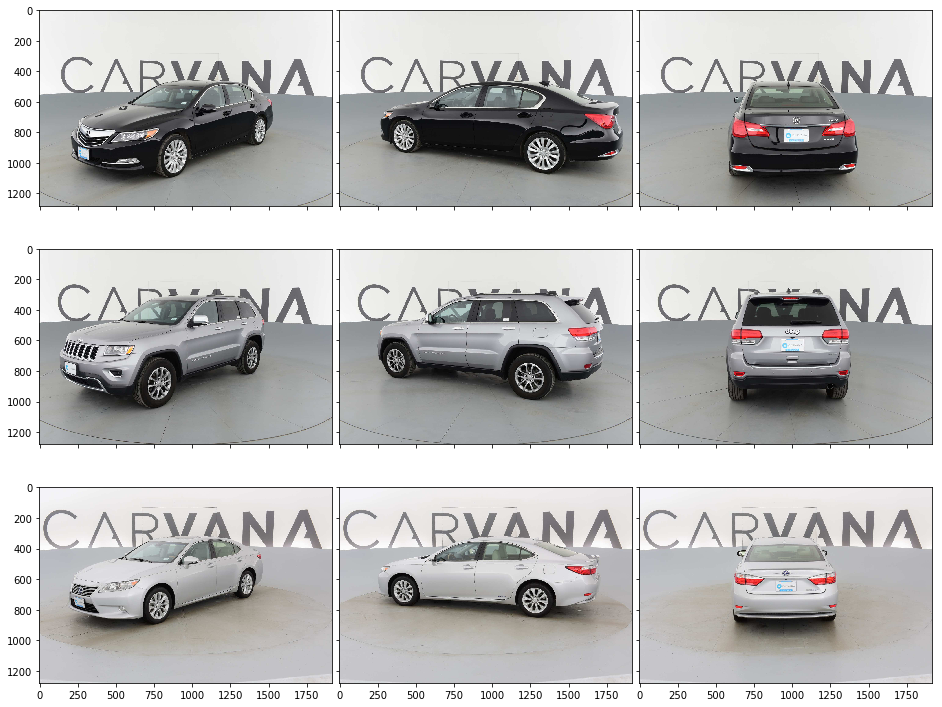

In [39]:
display(images, cols=3)

In [151]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [152]:
#resize_x, resize_y = 320, 240
resize_x, resize_y = 32, 32

In [153]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], resize_x, resize_y), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = cv2.resize(imgs[i], (resize_x, resize_y))

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [154]:
def get_unet():
    inputs = Input((resize_x, resize_y, 1))
    norm = Lambda(lambda x: x / 127.5 - 1)(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(norm)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [155]:
model = get_unet()

In [156]:
from skimage import io

def fliplr(img, y):
    return np.fliplr(img.copy()), y

def flipud(img, y):
    return np.flipud(img.copy()), y

def adjust_brightness(img, y, amount):
    result = img.astype(np.int16)
    result += amount
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result, y

def _augment(X, y):
    new_X, new_y = [], []
    def add(nx, ny):
        new_X.append(nx)
        new_y.append(ny)

    amount = int(random.uniform(5, 15))
    add(X, y)
    add(*fliplr(X, y))
    add(*flipud(X, y))
    add(*flipud(*fliplr(X, y)))
    #add(*adjust_brightness(*fliplr(X, y), amount))
    #add(*adjust_brightness(*flipud(X, y), -amount))
    #add(*adjust_brightness(*(X, y), amount))
    #add(*adjust_brightness(*(X, y), -amount))

    return new_X, new_y

def generator(X, y, augment=False, batch_size=32):
    X_copy, y_copy = X, y
    while True:
        for i in range(0, len(X_copy), batch_size):
            X_result, y_result = [], []
            for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                rx, ry = io.imread(x), io.imread(y)

                if augment:
                    rx, ry = _augment(rx, ry)
                else:
                    rx, ry = [rx], [ry]

                rx = np.array([preprocess(x) for x in rx])
                ry = np.array(ry)
                X_result.append(rx)
                y_result.append(ry)
            X_result, y_result = np.concatenate(X_result), np.concatenate(y_result)
            yield shuffle(X_result, y_result)
        X_copy, y_copy = shuffle(X_copy, y_copy)

In [157]:
model.compile(
    optimizer='adam',
    loss=dice_coef_loss
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 16, 16, 64)        36928     
__________

In [158]:
train_filenames = glob.glob('data/train/*.jpg')
mask_filenames = [fname.replace('train', 'train_masks').replace('.jpg', '_mask.gif') for fname in train_filenames]
X_train, X_valid, y_train, y_valid = train_test_split(train_filenames, mask_filenames, test_size=0.3)

In [159]:
EPOCHS = 4
BATCH = 128
PER_EPOCH = 32
print('Steps needed:', (len(y_train) // BATCH))

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

Steps needed: 27


In [145]:
history = model.fit_generator(
    generator(X_train, y_train, augment=False, batch_size=BATCH),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid, batch_size=BATCH),
    validation_steps=len(y_valid)//(2*BATCH),
#    callbacks=callbacks_list,
    pickle_safe=False
)

Epoch 1/4


ValueError: Error when checking model input: expected input_13 to have 4 dimensions, but got array with shape (128, 1280, 32, 32, 1)